In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from two_layer_net import TwoLayerNet
from keras.datasets import mnist
from common.functions import softmax

%matplotlib inline

Using TensorFlow backend.


In [2]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = mnist.load_data()

# 1次元へ整形
x_train, x_test = x_train.reshape(-1, 784), x_test.reshape(-1, 784)

# 正規化
x_train, x_test = x_train.astype(np.float32) / 255.0, x_test.astype(np.float32) / 255.0

In [3]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# パラメータのロード
network.load_params("params_nn.pkl")
print("loaded Network Parameters!")

loaded Network Parameters!


In [4]:
def generate_adv2(x, label, network, eps=0.01):
    d, g = network.gradient_for_fgsm(x, np.array([label]))
#     plt.imshow(d.reshape(28, 28), 'gray')
#     plt.show()
    p = eps * np.sign(d)
    adv = (x - p).clip(min=0, max=1)
#     plt.imshow(adv.reshape(28, 28), 'gray')
#     plt.show()
    return adv

In [5]:
def compare_eps(x, label, network, eps_list):
    fig = plt.figure(figsize=(15, 15))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    ax = fig.add_subplot(5, 5, 1)
    ax.imshow(x.reshape(28,28), 'gray')
    pre = network.predict(x)
    pre_label = np.argmax(pre)
    pre_score = round(max(softmax(pre[0])), 4)
    ax.set_title(f"base, {pre_label} : {pre_score}")

    for i, eps in enumerate(eps_list):
        adv = generate_adv2(x, label, network, eps)
        ax = fig.add_subplot(5, 5, i+2)
        ax.imshow(adv.reshape(28,28), 'gray')
        pre = network.predict(adv)
        pre_label = np.argmax(pre)
        pre_score = round(max(softmax(pre[0])), 4)
        ax.set_title(f"eps[{eps}], {pre_label} : {pre_score}")

    plt.show()

In [36]:
from IPython.core.display import HTML
import base64
import numpy as np
from io import BytesIO
from PIL import Image

numcanvas = '''
    使い方：<BR>
    ①黄色の範囲内にマウスでに数字を書きます<BR>
    <canvas id="numArea" height="28px" width="28px" 
    style="border: 3px double #999999; background-color:yellow;"></canvas>
    <BR>

    <button id="save">②このボタンを押すと数値（配列）に変換されます</button>
    <BR>
    （書き直す場合はセルを再実行して下さい）
    <script>
        var kernel = IPython.notebook.kernel;

        var currentX ;
        var currentY ;
        var isMoving = 0;

        var imgDecoded 
            = 'imgArray = np.asarray(Image.open(BytesIO(base64.b64decode(imgDataSp))))[:,:,3]'
        var save = document.getElementById("save");
        var numArea = document.getElementById("numArea");
        var context;
        if (numArea.getContext("2d")){
            context = numArea.getContext("2d");
        }

        save.addEventListener("click", function(){
            kernel.execute("imgData = '" + numArea.toDataURL() + "'");
            kernel.execute('imgDataSp = imgData.split(",")[-1]');
            kernel.execute('imgArray = '+imgDecoded);
        });

        numArea.addEventListener("mouseup", end, false);
        numArea.addEventListener("mousemove", move, false);
        numArea.addEventListener("mousedown", start, false);

        function end(evt){
            if(isMoving === 0){
               context.lineTo(currentX-1, currentY-1);
               context.lineWidth = 2;
               context.stroke();

            }
            isMoving = 0;
        }

        function move(evt){
          if(evt.buttons === 1 || evt.witch === 1 ){
            currentX = evt.layerX;
            currentY = evt.layerY;
            isMoving = 1;

            context.lineTo(currentX, currentY);
            context.lineWidth = 2;
            context.stroke();
          }
        }

        function start(evt){
          evt.preventDefault();
          context.beginPath();

          currentX = evt.layerX;
          currentY = evt.layerY;

          context.moveTo(currentX, currentY);
        }

    </script>
'''

HTML(numcanvas)

取り込んだ文字（拡大）


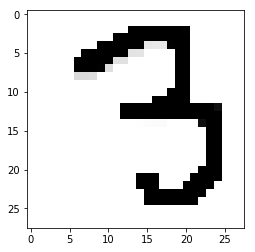

文字を①次元の配列に変換した数値を参照すると、0から255の値であることがわかります
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255 255 255
  255 255 255 255 253   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0 255 255 255 255 255 255 255 255 255 255   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0 255 255 255 255 255
  255  43  41  39 253 255 255   0   0   0   0   0   0   0   0   0   0   0
    0   0   0 253 255 255 255 255 255  49  48   0   0   0   0 255 255   0
    0   0   0   0   0   0   0   0   0   0   0   0 255 255 255 255 255  53
   52   0   0   0   0   0   0 255 255   0   0   0   0   0   0   0   0   0
    0   0   0   0 255 255 255 253  56   0   0   0   0   0   0   0   0 255
  255   0   0   0   0   0   0   0   0   0   0   0   0   0  61  61  58

In [37]:
print("取り込んだ文字（拡大）")
plt.imshow(imgArray, cmap="Greys")
plt.show()

print("文字を①次元の配列に変換した数値を参照すると、0から255の値であることがわかります")
imgArray_flatten = imgArray.reshape(1, 784)#1次元のベクトルに変換
print(imgArray_flatten)

In [38]:
def compare_base_adv(x, network, eps):
    fig = plt.figure(figsize=(20, 20))
    fig.subplots_adjust(wspace=0.4, hspace=0.1)
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(x.reshape(28,28), 'gray')
    pre = network.predict(x)
    pre_label = np.argmax(pre)
    pre_score = round(max(softmax(pre[0])), 3)
    ax.set_title(f"base, {pre_label} : {pre_score}")

    adv = generate_adv2(x, pre_label, network, eps)
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(adv.reshape(28,28), 'gray')
    pre = network.predict(adv)
    pre_label = np.argmax(pre)
    pre_score = round(max(softmax(pre[0])), 3)
    ax.set_title(f"{pre_label} : {pre_score}")

    plt.show()

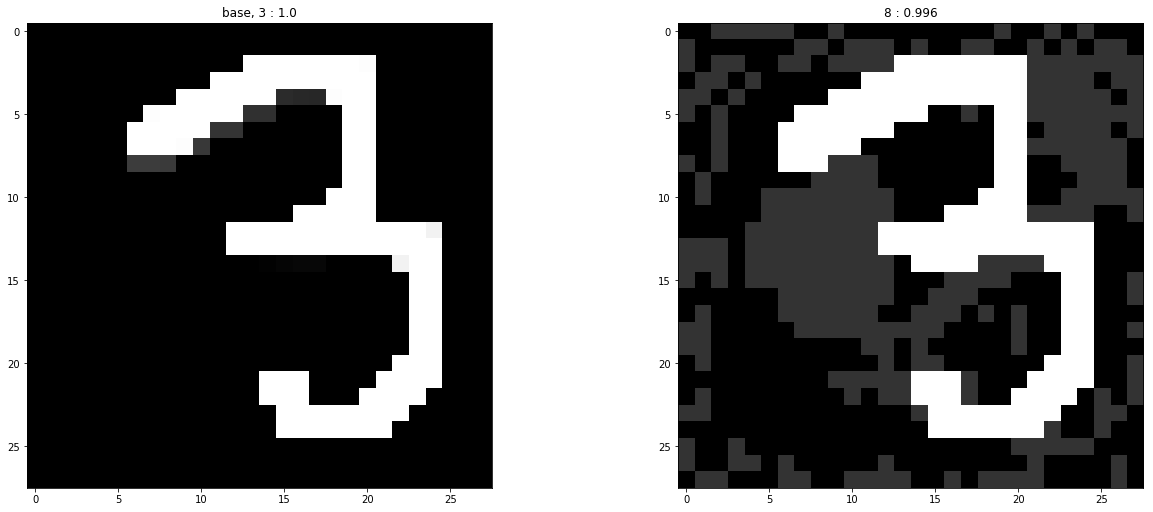

In [39]:
compare_base_adv(imgArray_flatten, network, 0.2)